In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import cv2
import albumentations as albu
import time
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [2]:
from segmentation_models_pytorch.utils import base,functional
from scipy import ndimage
from segmentation_models_pytorch.utils import base,functional
from segmentation_models_pytorch.base.modules import Activation
from segmentation_models_pytorch.utils.functional import _take_channels, _threshold
from sklearn.metrics import roc_auc_score
from torch.nn import functional as F

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def roc_auc_score(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate auc score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    auroc = torchmetrics.AUROC(average='macro', num_classes=1)
    auroc(pr.view(-1), gt.type(torch.uint8).view(-1))
    auc = auroc.compute()
    return auc

class AUC(base.Metric):

    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return roc_auc_score(
            y_pr, y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

def specificity(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate specificity score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: specificity score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp
    tn = gt.view(-1).shape[0] - tp - fp -fn

    score = (tn + eps) / (tn + fp + eps)

    return score


class Specificity(base.Metric):

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return specificity(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

def dice(pr, gt, eps=1e-7, threshold=0.5, ignore_channels=None):
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    dice_eff = ((2. * intersection) + eps) / (torch.sum(gt) + torch.sum(pr) + eps)
    return dice_eff

class Dice(base.Metric):

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return dice(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class focal_loss(nn.Module):

    def __init__(self, weight=None, reduction='mean', gamma=1, eps=1e-7):
        super(focal_loss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight, reduction=reduction)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

class FocalLoss(focal_loss, base.Loss):
    pass

In [3]:

image_path = "A. Segmentation/1. Original Images/a. Training Set/"
mask_dir3 = "A. Segmentation/2. Groundtruths/a. Training Set/3. Neovascularization/"
img_path3 = "A. Segmentation/train_data/3. Neovascularization/OI2/"
mask_path3 = "A. Segmentation/train_data/3. Neovascularization/GT2/"

def create_df(image_path):
    name = []
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

df = create_df(mask_dir3)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# train_id = df_train['id'].values
test_id = df_test['id'].values

In [4]:
len(test_id)

7

In [5]:
df1 = create_df(img_path3)
df_train3, df_val = train_test_split(df1, test_size=0.1, random_state=42)
train_id3 = df_train3['id'].values
val_id = df_val['id'].values
print(len(train_id3))
print(len(val_id))

151
17


In [6]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=(-90,90), shift_limit=0.1, p=1, border_mode=0),


        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),


        # albu.RandomBrightness(limit=0.4),
        # albu.RandomContrast(limit=0.4),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Sharpen(p=0.5),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
    
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
    


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        # albu.Lambda(image=to_tensor)
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [7]:
class ImageDataset(Dataset):
    
    def __init__(self, img_path, mask_path, img_id, augmentation=None, preprocessing=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_id = img_id
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        self.class_values = [255]

    
    def __getitem__(self, idx):
        image = cv2.imread(self.img_path + self.img_id[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        mask = cv2.imread(self.mask_path + self.img_id[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
   
        
        # apply preprocessing
        if self.preprocessing is not None:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        return image, mask

    def __len__(self):
        return len(self.img_id)

In [8]:
CLASSES = ['NV']
len(CLASSES)

1

In [ ]:
# model2 = smp.DeepLabV3(
#     encoder_name="resnet34",        
#     encoder_weights="imagenet",     
#     in_channels=3,                  
#     classes=1,
#     activation='sigmoid'                        
# )

# for param in model2.parameters():    
#     param.requires_grad = True
# print("model",model2)

In [ ]:
# model = smp.UnetPlusPlus(
#     encoder_name="resnet34",        
#     encoder_weights="imagenet",     
#     in_channels=3,                  
#     classes=1,
#     activation='sigmoid'                        
# )

# for param in model.parameters():    
#     param.requires_grad = True
# print("model",model)

In [9]:
model = smp.Unet(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,
    activation='sigmoid'                        
)

for param in model.parameters():    
    param.requires_grad = True
print("model",model)

model Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [15]:
ENCODER = 'resnet50'
# ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_set = ImageDataset(img_path3, mask_path3, train_id3, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
val_set = ImageDataset(img_path3, mask_path3, val_id, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

c:\Users\18055\anaconda3\envs\DL\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [17]:
for batch_idx, (img, mask) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print("image shape:", img.shape)
    print("image type:", img.dtype)
    print("mask shape:", mask.shape)
    print("mask type:", mask.dtype)
    break

Batch 1:
image shape: torch.Size([4, 3, 512, 512])
image type: torch.float32
mask shape: torch.Size([4, 1, 512, 512])
mask type: torch.float32


In [16]:
for batch_idx, (img, mask) in enumerate(val_loader):
    print(f"Batch {batch_idx+1}:")
    print("image shape:", img.shape)
    print("image type:", img.dtype)
    print("mask shape:", mask.shape)
    print("mask type:", mask.dtype)
    break

Batch 1:
image shape: torch.Size([1, 3, 1024, 1024])
image type: torch.float32
mask shape: torch.Size([1, 1, 1024, 1024])
mask type: torch.float32


In [18]:
loss = smp.utils.losses.DiceLoss()
metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
        Dice(threshold=0.5)
        # smp.utils.metrics.Dice(threshold=0.5),
        # AUC(threshold=0.5),
        # smp.utils.metrics.Recall(threshold=0.5),
        # Specificity(threshold=0.5)
    ]

optimizer = torch.optim.Adam([
        dict(params=model.parameters(), lr=1e-4), # origin 0.0001
    ])

scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.6)

In [19]:
DEVICE = 'cuda'
train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
        verbose=True,
    )

In [20]:
max_score = 0
best_epoch = 0

log_txt = open('./logs/'+'NE_best_model1.txt', 'w')

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)

    log_txt.write('\nEpoch: {} '.format(i))
    log_txt.write('iou_score: {} '.format(valid_logs['iou_score']))
    log_txt.write('dice_score: {} '.format(valid_logs['dice']))
    log_txt.flush()

        # do something (save model, change lr, etc.)
    if max_score < valid_logs['dice']:
        max_score = valid_logs['dice']
        # if max_score < valid_logs['iou_score']:
        #     max_score = valid_logs['iou_score']
        best_epoch = i
        torch.save(model, './model/week3/NE_model100-1.pth')
        print('Model saved!')
    
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    
log_txt.write('\nBest epoch: {} '.format(best_epoch))
log_txt.write('Best dice_score: {} '.format(max_score))
log_txt.flush()
log_txt.close()


Epoch: 0
valid: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s, dice_loss - 0.9727, iou_score - 0.03078, dice - 0.05613]
Model saved!

Epoch: 1
valid: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s, dice_loss - 0.9483, iou_score - 0.08061, dice - 0.1378]
Model saved!

Epoch: 2
valid: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s, dice_loss - 0.9488, iou_score - 0.06479, dice - 0.1146]

Epoch: 3
valid: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s, dice_loss - 0.9352, iou_score - 0.1623, dice - 0.2648]
Model saved!

Epoch: 4
valid: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s, dice_loss - 0.9327, iou_score - 0.1618, dice - 0.2613] 

Epoch: 5
valid: 100%|██████████| 17/17 [00:04<00:00,  3.88it/s, dice_loss - 0.9394, iou_score - 0.196, dice - 0.2861] 
Model saved!

Epoch: 6
valid: 100%|██████████| 17/17 [00:04<00:00,  3.87it/s, dice_loss - 0.9186, iou_score - 0.1074, dice - 0.1812]

Epoch: 7
valid: 100%|██████████| 17/17 [00:03<00:00,  5.11it/s, dice_loss - 0.9214, iou_score - 0.1729

In [21]:
test_dataset = ImageDataset(image_path, mask_dir3, test_id, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_dataloader = DataLoader(test_dataset)

In [22]:
best_model = torch.load('./model/week3/NE_model100-1.pth')
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s, dice_loss - 0.4395, iou_score - 0.4519, dice - 0.6011]


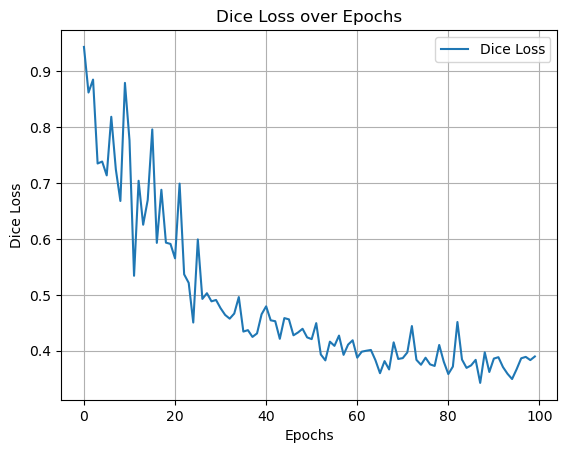

In [8]:
dice_loss_values = []
with open('./logs/NE_best_model1.txt', 'r') as log_file:
    for line in log_file:
        if 'dice_score:' in line:
            dice_loss = 1 - float(line.split('dice_score: ')[1])
            dice_loss_values.append(dice_loss)
        elif 'Best epoch:' in line:
            break  # Stop reading the file after the last epoch's information is read

dice_loss_values = dice_loss_values[:-1] 
epochs = range(0, 100)

plt.plot(epochs, dice_loss_values, label='Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.title('Dice Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

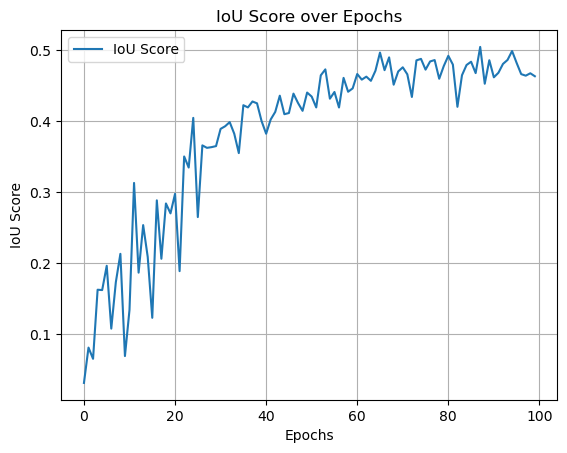

In [9]:

iou_score_values = []
# Read the log file and extract IoU score values
with open('./logs/NE_best_model1.txt', 'r') as log_file:
    for line in log_file:
        if 'iou_score:' in line:
            iou_score = float(line.split('iou_score: ')[1].split()[0])
            iou_score_values.append(iou_score)
        elif 'Best epoch:' in line:
            break  # Stop reading the file after the last epoch's information is read

epochs = range(0, len(iou_score_values))  # Adjust the number of epochs based on available data

# Plot the IoU score graph
plt.plot(epochs, iou_score_values, label='IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('IoU Score over Epochs')
plt.legend()
plt.grid()
plt.show()

In [24]:
test_id

array(['458', '212', '443', '421', '230', '498', '414'], dtype=object)

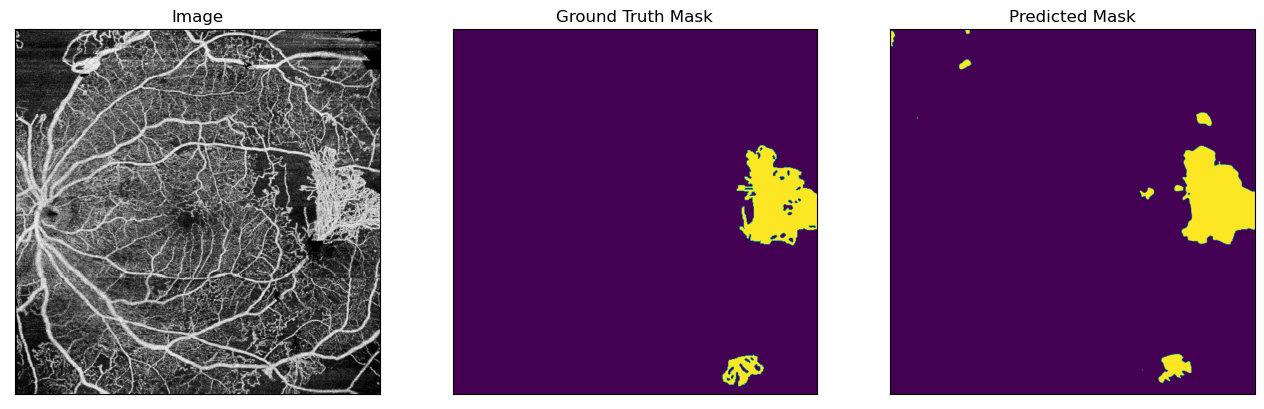

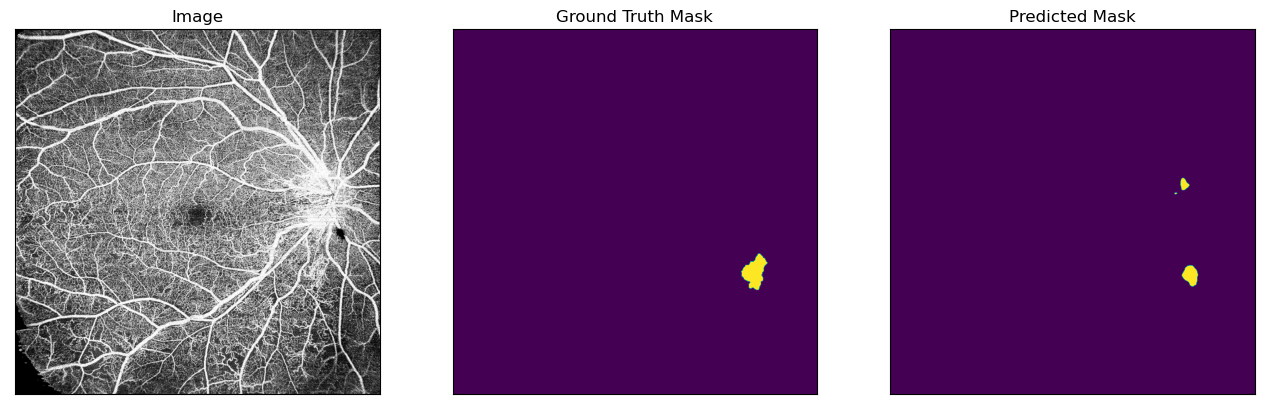

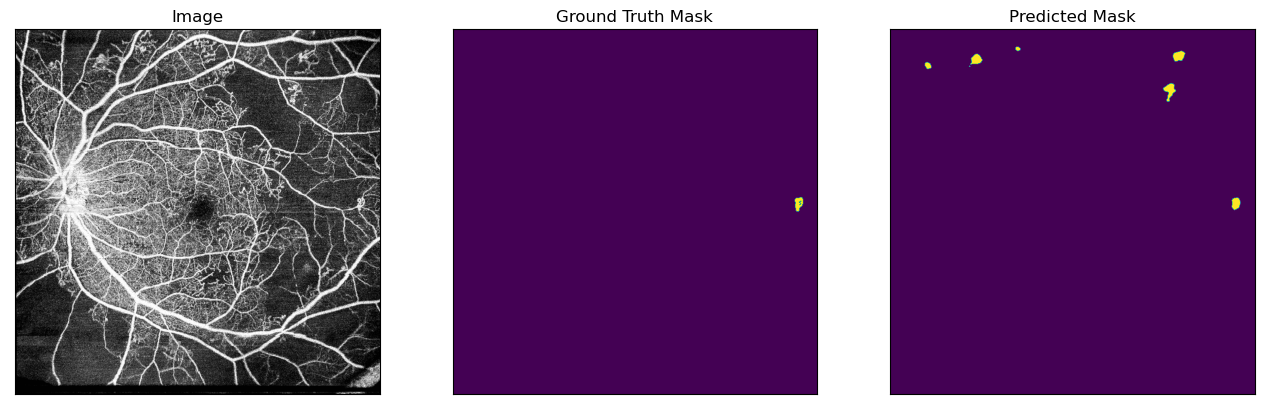

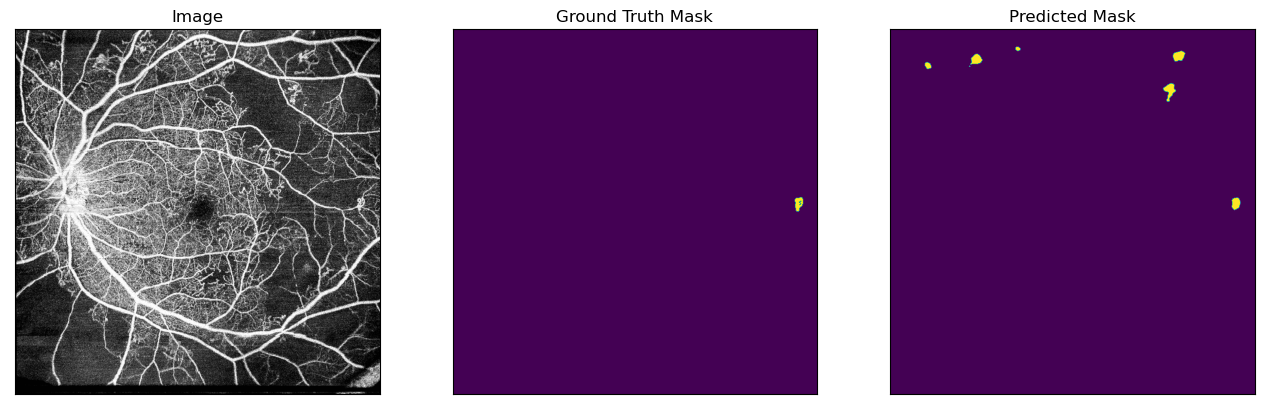

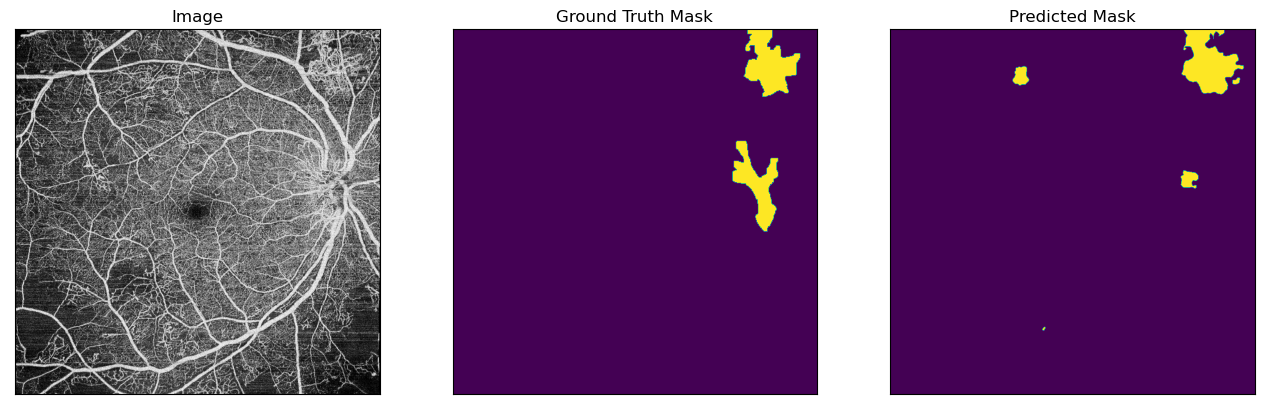

In [23]:
test_set_vis = ImageDataset(image_path, mask_dir3, test_id)
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_set_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )